
\cleardoublepage

# Implemented pipeline layers

In this section the actual implementation of a machine learning pipeline is described. A machine learning pipeline consists of several layers, which can be grouped into extract-transform-load (ETL), pre-processing and modeling (see @sec:composition_pipeline). Each subsection describes a different layer in the pipeline. The order of the subsection reflects the order of the layers in the implementation. Some layers are always required, some are optional and some are mutually exclusive, e.g. if two models that cannot be combined. Some of the layers are specific to the data set used, but most layers are applicable to different data sets. A layer might have various configuration options or in the case of the modeling-layers also different architectures.



In [1]:
%load_ext autoreload
%autoreload 2
import yaml
import pprint
yaml_config = \
"""
01_etl:
  data_set_dir: '/home/fabian/repositories/masterthesis_reloaded/data/HAPT Data Set'
  download_url: 'https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip'
  data_split:
    train_participant_ids: [20,  6, 22, 18, 26, 27,  3, 11, 13, 30, 19, 12, 10, 17, 21,  4, 14, 24]
    test_participant_ids: [16, 28,  2,  1, 23, 25]
    validation_participant_ids: [ 7,  9, 15, 29,  8,  5]
  selected_labels: [1,2,3,4,5,6]
  channel_names_prior_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'acc-X', 'acc-Y', 'acc-Z']
  channel_names_post_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'body-X', 'body-Y', 'body-Z', 'gravity-X', 'gravity-Y', 'gravity-Z']
  sequence_length: 128
  sequence_stepsize: 64
  drop_columns: ['participant_id', 'experiment_id', 'time'] # the columns are loaded initially, because they are needed to sort and group data, but should not be used for modeling  
  group_column: 'experiment_id' # data is sequenced within these groups
  sample_rate: 50
02_preprocessing:
  sample_rate: 50
  median_filter_kernel: 3
  acc_columns_idx: [3,4,5] # indices of columns that contain the acceleration data
"""
config = yaml.load(yaml_config)
etl_config = config['01_etl']
preprocessing_config = config['02_preprocessing']



## ETL layer: loading and splitting

The raw data is loaded from different files in permanent storage into memory and merged into a single data object. The raw sensory data consists of 60 separate data files representing data from different sessions. The labels are again in a separate file. All these files are loaded and merged into one data object. This data object is then split into a train, test and validation set based on participant ids specified in the config. If the data is not in the data folder specified in the config the data is downloaded first from the UCI machine learning repository and extracted. See @tbl:dimensions_data for the shape of the data after this layer.



In [2]:
import sys
sys.path.append('code')
from etl_hapt import get_Xy_data_sets, get_y_translations, split_X_y, select_labels
df_Xy_train, df_Xy_test, df_Xy_validation = \
    get_Xy_data_sets(
        etl_config['data_set_dir'],
        etl_config['download_url'],
        ids_train=etl_config['data_split']['train_participant_ids'],
        ids_test=etl_config['data_split']['test_participant_ids'],
        ids_validation=etl_config['data_split']['validation_participant_ids'],
        )






Xy shape:  (1122772, 10)


## ETL layer: sequencing
The output of this pipeline are discrete classifications, while the inputs are streams of observations sampled at 50Hz representing a continuous signal from different sensors. As each data point represents only a 50th of a second it will not provide enough information for an algorithm to classify single data points. Classifying the entire stream is not possible either, because it contains different behaviors that belong to different classes. It is therefore necessary to slice the stream into separate sequences (or windows), which can then be classified. When sequencing the data, two parameters can be set. The length of the sequence and distance between the starting points of succeeding sequences. The sequence should be long enough to reflect patterns related to the different behaviors to classify. The maxmium length depends on how quickly the behavior changes and which sequence lengths the modeling algorithms can deal with. For example, LSTMs can deal with sequence lengths of up to 300. The stepsize depends on how much overlap of sequences makes sense and how often a classification is needed. See @tbl:dimensions_data for the shape of the data after applying a *sequence length* of *128* and a *sequence stepsize* of *64* (parameters taken from authors of data @reyes-ortiz_transition-aware_2016).



In [3]:
from sequencers import sequence_dataframe, remove_sequences_containing_nan_values, remove_sequences_without_unique_labels
seq_Xy_train = sequence_dataframe(df_Xy_train,
                        etl_config['sequence_length'],
                        etl_config['sequence_stepsize'],
                        group_column=etl_config['group_column'],
                        drop_columns=etl_config['drop_columns'])
seq_Xy_test = sequence_dataframe(df_Xy_test,
                       etl_config['sequence_length'],
                        etl_config['sequence_stepsize'],
                        group_column=etl_config['group_column'],
                        drop_columns=etl_config['drop_columns'])
seq_Xy_validation = sequence_dataframe(df_Xy_validation,
                       etl_config['sequence_length'],
                        etl_config['sequence_stepsize'],
                        group_column=etl_config['group_column'],
                        drop_columns=etl_config['drop_columns'])



kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (10684, 128, 7)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (3666, 128, 7)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (3103, 128, 7)


In [4]:
from plotting import plot_raw_hapt_data_with_labels_and_sequences
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 4]
plt.rcParams.update({'font.size': 14})
plot_raw_hapt_data_with_labels_and_sequences(df_Xy_train, 5, 3500, 10000, etl_config, 'figures/default_etl_raw_labels_sequences.png')


![Sequencing of raw data. Sequences are 128 samples long and overlap by 50%, i.e. every sequence shifts 64 samples. Sequences are displayed in multiple rows so they are visually distinct. The background color indicates if the current data point is labeled as an activity or a transition. If the background is not colored no label is available. Only sequences with a distinct label are kept.](figures/default_etl_raw_labels_sequences.png){#fig:sequences_labels_dropped}



## ETL layer: sequence cleaning {#sec:etl_layer_seq_cleaning}
Next, sequences that contain unlabeled observations and sequences that contain observations with different labels are dropped (sequences with white fill in @fig:sequences_labels_dropped). Now, each sequence has a distinct label. When applying the model to new data this layer is not applied because no labels will exist. However, for training it is important that the sequences have a distinct label. See @tbl:dimensions_data for the shape of the data after this layer.



In [5]:
Xy_train_cleaned = remove_sequences_containing_nan_values(seq_Xy_train)
Xy_test_cleaned = remove_sequences_containing_nan_values(seq_Xy_test)
Xy_validation_cleaned = remove_sequences_containing_nan_values(seq_Xy_validation)

index_last_column = -1
Xy_train_cleaned = remove_sequences_without_unique_labels(
                      Xy_train_cleaned, column_containing_labels=index_last_column)
Xy_test_cleaned = remove_sequences_without_unique_labels(
                      Xy_test_cleaned, column_containing_labels=index_last_column)
Xy_validation_cleaned = remove_sequences_without_unique_labels(
                          Xy_validation_cleaned, column_containing_labels=index_last_column)



## ETL layer: separating input and output features


In [6]:
index_last_column = -1
X_train, y_train = split_X_y(Xy_train_cleaned, index_last_column)
X_test, y_test = split_X_y(Xy_test_cleaned, index_last_column)
X_validation, y_validation = split_X_y(Xy_validation_cleaned, index_last_column)


The input and output features need to be passed to the models separately, so the data sets (train, test & validation) containing the sequences need to be split to input features (x) and the output feature (y). The output feature sequences now hold a lot of redundant information as they contain a label for each observation in the sequence. However, all of these labels are the same within a sequence since after the cleaning (@sec:etl_layer_seq_cleaning). Therefore, the length of the output vector within each sequence can be reduced from *128* (sequence length) to *1*. see @tbl:dimensions_data for the shape of the data after this layer.





## ETL layer: label selection {#sec:default_etl_label_selection}


In [7]:
from etl_hapt import select_labels
X_train_subset, y_train_subset = select_labels(X_train, y_train, etl_config['selected_labels'])
X_test_subset, y_test_subset = select_labels(X_test, y_test, etl_config['selected_labels'])
X_validation_subset, y_validation_subset = select_labels(X_validation, y_validation, etl_config['selected_labels'])




Once all sequences have a unique label, we can filter the labels we want our algorithm to train on, i.e. in this case select particular activities or transitions. See @tbl:activities_and_transitions for an overview of all activities and transitions present in the data. See @tbl:dimensions_data how the data set size changes after keeping only the activities and dropping the transitions.

Type | Label | Name
---|---|---
activity | 1 | walking           
activity | 2 | walking upstairs  
activity | 3 | walking downstairs
activity | 4 | sitting           
activity | 5 | standing          
activity | 6 | laying            
transition | 7  | stand to sit      
transition | 8  | sit to stand      
transition | 9  | sit to lie        
transition | 10 |  lie to sit        
transition | 11 |  stand to lie      
transition | 12 |  lie to stand    

: Overview of activity and transition labels present in the data. {#tbl:activities_and_transitions}



## ETL layer: Recoding output to binary features


In [8]:
from sklearn.preprocessing import label_binarize

y_train_cat = label_binarize(y_train, etl_config['selected_labels'])
y_test_cat = label_binarize(y_test, etl_config['selected_labels'])
y_validation_cat = label_binarize(y_validation,
                                  etl_config['selected_labels'])




The multi-categorical output feature is recoded into binary features - one feature for each category in the original feature. This is called one-hot-encoding and advisable for many algorithms to perform well in multi-classification tasks. The original output feature is dropped. See @tbl:dimensions_data for how the data set size changes after applying this layer.



## Pre-processing layer: noise reduction in input


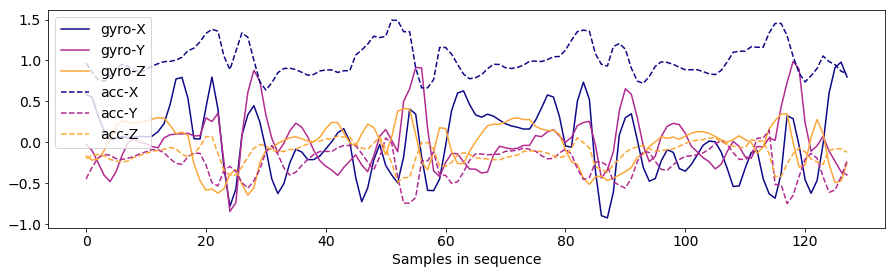

In [9]:
from filters import medfilt_3d_array
from plotting import plot_all_columns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [15, 4]
plot_all_columns(X_train_subset[100], etl_config['channel_names_prior_preprocess'], 'figures/default_etl_sequence_before_median_filter.png')
X_train[100].shape
X_train_med = medfilt_3d_array(X_train_subset)
X_test_med = medfilt_3d_array(X_test_subset)
X_validation_med = medfilt_3d_array(X_validation_subset)



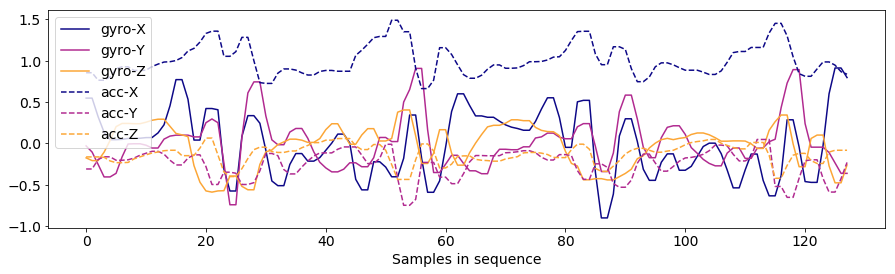

In [10]:
plot_all_columns(X_train_med[100], etl_config['channel_names_prior_preprocess'])
plt.savefig('figures/default_etl_sequence_after_median_filter.png', bbox_inches='tight')



The raw data contains noise that is removed using a median filter as the authors of the data did [@reyes-ortiz_transition-aware_2016]. See @fig:sequence_before_median_filter and @fig:sequence_after_median_filter.




## Pre-processing layer: separating bodily and gravitational acceleration



/home/fabian/.miniconda3/envs/masterthesis_tf_keras/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Shape BEFORE separating acc and body:  (6128, 128, 6)
Shape AFTER separating acc and body:  (6128, 128, 9)
Shape BEFORE separating acc and body:  (2105, 128, 6)
Shape AFTER separating acc and body:  (2105, 128, 9)
Shape BEFORE separating acc and body:  (1784, 128, 6)
Shape AFTER separating acc and body:  (1784, 128, 9)


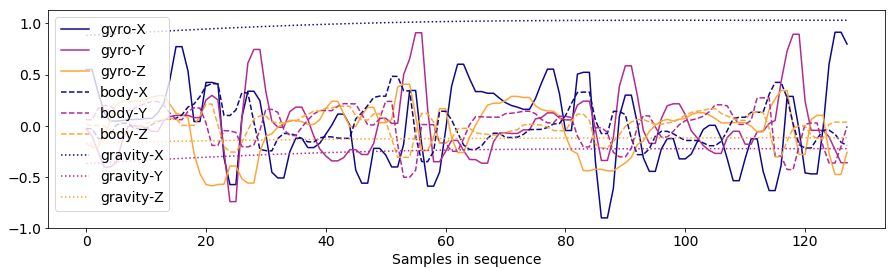

In [11]:
from filters import separate_acc_to_body_gravity
from plotting import plot_all_columns
X_train_bg = separate_acc_to_body_gravity(X_train_med, preprocessing_config['acc_columns_idx'], preprocessing_config['sample_rate'])
X_test_bg = separate_acc_to_body_gravity(X_test_med, preprocessing_config['acc_columns_idx'], preprocessing_config['sample_rate'])
X_validation_bg = separate_acc_to_body_gravity(X_validation_med, preprocessing_config['acc_columns_idx'], preprocessing_config['sample_rate'])

# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 14})
plot_all_columns(X_train_bg[100], etl_config['channel_names_post_preprocess'], 'figures/default_etl_sequence_after_separating_body_gravity_acc.png')





The data from the accelerometer holds both body and gravitational components, which are easier to distinguish during modeling if separated before (@fig:sequence_after_separating_body_gravity_acc) [@veltink_detection_1996;@van_hees_separating_2013]. Also this step is performed similar to the authors of the data [@reyes-ortiz_transition-aware_2016]. See @tbl:dimensions_data for the shape of the data after this layer.


![Raw sensory data before applying a median filter](figures/default_etl_sequence_before_median_filter.png){#fig:sequence_before_median_filter}


![Raw sensory data after applying a median filter with *kernel size = 3*.](figures/default_etl_sequence_after_median_filter.png){#fig:sequence_after_median_filter}


![After separating body and gravity components from the acceleration data.](figures/default_etl_sequence_after_separating_body_gravity_acc.png){#fig:sequence_after_separating_body_gravity_acc}



In [12]:
import numpy as np
print(
'''
State and dimension labels | train set | test set | validation set
------- | --- | --- | ---
Loaded sets Xy (o,f) | %s | %s | %s
Sequenced sets Xy (s,o,f) | %s | %s | %s
Cleaned sets Xy (s,o,f) | %s | %s | %s
Separate set X (s,o,f) | %s | %s | %s
Separate set y (s,f) | %s | %s | %s
Activity selection X (s,o,f) | %s | %s | %s
Activity selection y (s,f) | %s | %s | %s
Binary encoded y (s,f) | %s | %s | %s
Body & gravity X (s,o,f) | %s | %s | %s

: Number of items within different dimensions of the data sets after passing through various layers in the pipeline: *o=number of observations*, *f=number of features*, *s=number of sequences*. Note, the sequenced data sets are three-dimensional. X denotes the input features, y the output features. The number of features in the one-hot-encoding equals the number of selected activities (*%d* in this case). The sequence length and stepsize used for sequencing are *%d* and *%d*, respectively. {#tbl:dimensions_data}
''' % (
  df_Xy_train.shape, df_Xy_test.shape, df_Xy_validation.shape,
  seq_Xy_train.shape, seq_Xy_test.shape, seq_Xy_validation.shape,
  Xy_train_cleaned.shape, Xy_test_cleaned.shape, Xy_validation_cleaned.shape,
  X_train.shape, X_test.shape, X_validation.shape,
  y_train.shape + (1,), y_test.shape + (1,), y_validation.shape + (1,),
  X_train_subset.shape, X_test_subset.shape, X_validation_subset.shape,
  y_train_subset.shape + (1,), y_test_subset.shape + (1,), y_validation_subset.shape + (1,),
  y_train_cat.shape, y_test_cat.shape, y_validation_cat.shape,
  X_train_bg.shape, X_test_bg.shape, X_validation_bg.shape,
  len(etl_config['selected_labels']), etl_config['sequence_length'],
  etl_config['sequence_stepsize']
)
)




State and dimension labels | train set | test set | validation set
------- | --- | --- | ---
Loaded sets Xy (o,f) | (687249, 10) | (235711, 10) | (199812, 10)
Sequenced sets Xy (s,o,f) | (10684, 128, 7) | (3666, 128, 7) | (3103, 128, 7)
Cleaned sets Xy (s,o,f) | (6350, 128, 7) | (2173, 128, 7) | (1838, 128, 7)
Separate set X (s,o,f) | (6350, 128, 6) | (2173, 128, 6) | (1838, 128, 6)
Separate set y (s,f) | (6350, 1) | (2173, 1) | (1838, 1)
Activity selection X (s,o,f) | (6128, 128, 6) | (2105, 128, 6) | (1784, 128, 6)
Activity selection y (s,f) | (6128, 1) | (2105, 1) | (1784, 1)
Binary encoded y (s,f) | (6350, 6) | (2173, 6) | (1838, 6)
Body & gravity X (s,o,f) | (6128, 128, 9) | (2105, 128, 9) | (1784, 128, 9)

: Number of items within different dimensions of the data sets after passing through various layers in the pipeline: *o=number of observations*, *f=number of features*, *s=number of sequences*. Note, the sequenced data sets are three-dimensional. X denotes the input features, 



## Pre-processing layer: normalization




All of the input features are normalized to have a *mean* of *0* and a *standard deviation* of *1*. This layer is still considered to be pre-processing, although actually a mini-model (the mean and standard deviation) is fitted to the train data set and kept to apply it to new data later including the test and validation sets.

## Modeling layer: LSTM
This layer contain a particular kind of recurrent neural network using long-short-term-memory (LSTM) cells [@gers_learning_1999]. Neural networks are capable of representation learning (see @sec:theory_feature_engineering), i.e. they can extract the most relevant patterns in raw data without prior manual feature engineering. Specifically, LSTMs are capable of learning patterns across long time lags, which makes them well suited for classifying the human behaviors present in the sensory data in the HAPT data set. LSTMS can have different architectures, i.e. a combination of one or more layers. Also, various hyperparameters can be set, like loss functions (a proxy perfomance function), activation functions (how input is converted within the network), optimizers (which parameters to try next), dropout (against over-fitting) and regularizers (keeping the parameters within certain limits).
